# Chapter 4 - Simultaneous Inferences and Other Topics in Regression Analysis

# 4.1 Joint Estimationof $\beta_0$ and $\beta_1$ (p 154)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.api import het_breuschpagan, anova_lm
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats


DATA_DIR = "../alsm/data"
yhat = '\u0177'
square = '\u00b2'

### Input the Toluca Company Data

In [34]:
df = pd.read_pickle(f"{DATA_DIR}/CH01TA01.xz")
df.columns = ['x', 'y']
model = ols("y ~ x", data=df).fit()

### Bonferroni Joint Confidence Intervals (p 156)

The short of this procedure is that we're just tweaking the alpha value we pass to the confidence interval function (whether `conf_int` in python or `confint` in R). What this section teaches is really the theory around the alpha value we're selecting for the *family* confidence coeficient. 

For the standard 95 percent confidence level, we choose $\alpha=0.05$ to produce the standard t statistic $t(1-\frac{\alpha}{2}; n-2)=t(0.975; n-2)$. 

The Bonferroni correction for a 90 percent *family* confidence interval, we adjust the chosen $\alpha=0.10$ by a factor of $1-\frac{\alpha}{2g}$ where g here is the number of parameters in the family (for simple regression this is 2). Thus, by simple math we see that  

$1-\frac{0.1}{2g}=1-\frac{0.1}{4}=1-0.025=1-\frac{0.05}{2}=0.975$

But this is the same thing as the individual 95 percent confidence interval. Therefore, to generate the corrected value requires no more sophistication than modifying the alpha value to `conf_int`. The 90 percent family confidence level for 2 parameters is equivalent to the individual coefficient 95 percent confidence level. 

In [35]:
display(model.summary())
display(model.conf_int(alpha = 0.1 / 2))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           4.45e-10
Time:                        20:38:19   Log-Likelihood:                -131.64
No. Observations:                  25   AIC:                             267.3
Df Residuals:                      23   BIC:                             269.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3659     26.177      2.382      0.026       8.214     116.518
x              3.5702      0.347     10.290      0.000       2.852       4.288
==============================================================================
Omnibus:                        0.608   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.684
Skew:                           0.298   Prob(JB):                        0.710
Kurtosis:                       2.450   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,0,1
Intercept,8.213711,116.518006
x,2.852435,4.287969


# 4.2 Simultaneous Estimation of Mean Responses (p 157)

### Example (p 158-159)

Here we revisit the Working-Hotelling Procedure from chapter 2 (p 61) and supply specific values of `x` to estimate.

In [36]:
W = np.sqrt(2 * stats.f.ppf(1-0.1, 2, 23))
xh = pd.DataFrame({"x": [30, 65, 100]})
yh = model.get_prediction(xh).summary_frame(alpha=0.1)
yh = pd.concat([xh, yh], axis=1)
yh["wh_ci_lower"] = yh["mean"] - W*yh.mean_se
yh["wh_ci_upper"] = yh["mean"] + W*yh.mean_se
display(yh.sort_values("x"))

,x,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,wh_ci_lower,wh_ci_upper
0,30,169.471919,16.969741,140.387963,198.555875,80.884691,258.059147,131.154188,207.789651
1,65,294.428990,9.917579,277.431534,311.426446,209.043195,379.814785,272.035064,316.822916
2,100,419.386061,14.272328,394.925125,443.846996,332.207177,506.564945,387.159097,451.613024


In this instance, we use the Bonferroni correction demonstrated earlier. The same tweak applies, but here $g=3$. So for a 90 percent *family* confidence coefficient, we need to pass our functions an $\alpha$ value that will produce 

$1-\frac{0.10}{2g}=1-\frac{0.10}{6}=1-0.01666667=0.98333$

But notice that what we actually pass in will just be $\frac{\alpha}{g}$ because the function will provide the $\alpha$ to the $1-\frac{\alpha}{2}$ confidence level. So to get $1-\frac{\alpha}{2}=0.983333$ we just pass in $\frac{\alpha}{g}$

In [37]:
family_alpha = 0.10
xh = pd.DataFrame({"x": [30, 65, 100]})
g = len(xh)
yh = model.get_prediction(xh).summary_frame(alpha=family_alpha/g)
display(pd.concat([xh, yh], axis=1))

,x,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,30,169.471919,16.969741,131.057035,207.886803,52.463487,286.480351
1,65,294.428990,9.917579,271.978286,316.879694,181.649099,407.208881
2,100,419.386061,14.272328,387.077388,451.694733,304.237808,534.534313


# 4.3 Simultaneous Prediction Intervals for New Observations (p 160)

### Example (p 160)

There is no direct calculation to produce these results, but between the `stats` package and the moel object, computing these values is pretty easy. I leave it to the interested reader to wrap these common adjustments into a single package!

Notice, the `obs_ci_lower` and `obs_ci_upper` correspond exactly to the Bonferroni corrected limits at this 95 percent family confidence interval. Is that by chance? 

In [38]:
xh = pd.DataFrame({"x": [80, 100]})
family_alpha = 0.05
g = len(xh)
yh = model.get_prediction(xh).summary_frame(alpha=0.05/g)
yh = pd.concat([xh, yh], axis=1)

spred = np.sqrt(model.mse_resid + yh.mean_se**2)
B = stats.t.ppf(1-family_alpha/(2*g), model.nobs-2)
S = np.sqrt(g*stats.f.ppf(1-family_alpha, g, model.nobs-2))
display(pd.DataFrame({"Multipliers": [B, S]}, index=['Bonferroni', 'Scheffe']))

yh["bon_ci_lower"] = yh["mean"]-B*spred
yh["bon_ci_upper"] = yh["mean"]+B*spred
yh

,Multipliers
Bonferroni,2.397875
Scheffe,2.616155


,x,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,bon_ci_lower,bon_ci_upper
0,80,347.982020,10.362798,323.133324,372.830716,228.301791,467.662249,228.301791,467.662249
1,100,419.386061,14.272328,385.162802,453.609319,297.414216,541.357906,297.414216,541.357906


### Input the Warehouse Data

# 4.4 Regression through Origin (p 161)

In [39]:
df = pd.read_pickle(f"{DATA_DIR}/CH04TA02.xz")
df.columns = ['x', 'y']
model_std = ols("y ~ x", data=df).fit()
model = ols("y ~ 0 + x", data=df).fit()

### Table 4.2 (p 163)

Regression through Origin -- Warehouse Example

In [40]:
pd.DataFrame({
    "Work Units Performed (x)": df.x,
    "Variable Labor Costs (y)": df.y,
    "XiYi": df.x*df.y,
    "Xi2": df.x**2,
    yhat: model.fittedvalues,
    "ei": model.resid
})

,Work Units Performed (x),Variable Labor Costs (y),XiYi,Xi2,ŷ,ei
0,20,114,2280,400,93.705482,20.294518
1,196,921,180516,38416,918.313726,2.686274
2,115,560,64400,13225,538.806523,21.193477
3,50,245,12250,2500,234.263706,10.736294
4,122,575,70150,14884,571.603442,3.396558
5,100,475,47500,10000,468.527411,6.472589
6,33,138,4554,1089,154.614046,-16.614046
7,154,727,111958,23716,721.532213,5.467787
8,80,375,30000,6400,374.821929,0.178071
9,147,670,98490,21609,688.735294,-18.735294


### Figure 4.1 (p 163)

Scatter Plot and Fitted Regression through Origin -- Warehouse Example

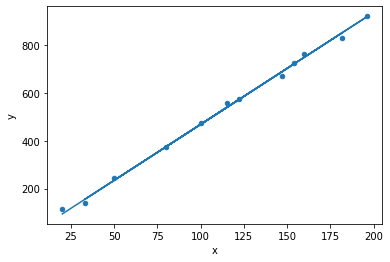

In [41]:
df.plot.scatter('x', 'y')
plt.plot(df.x, model.fittedvalues)

For comparison, I present a model with a separate intercept term, but all book calculations are directly observable from the summary or ANOVA output. Calculations can be done pretty easily using the model components. For details on that, see [statsmodels.regression.linear_model.RegressionResults](https://www.statsmodels.org/v0.12.1/generated/statsmodels.regression.linear_model.RegressionResults.html)

In [42]:
display(model.summary())
display(anova_lm(model, typ=1))

C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.876e+04
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    3.93e-19
Time:                        20:38:20   Log-Likelihood:                         -48.960
No. Observations:                  12   AIC:                                      99.92
Df Residuals:                      11   BIC:                                      100.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              4.6853      0.034    136.976      0.000       4.610       4.761
==============================================================================
Omnibus:                        1.104   Durbin-Watson:                   1.482
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                0.902
Skew:                          -0.542   Prob(JB):                        0.637
Kurtosis:                       2.207   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,df,sum_sq,mean_sq,F,PR(>F)
x,1.0,4.191980e+06,4.191980e+06,18762.479912,3.932403e-19
Residual,11.0,2.457659e+03,2.234236e+02,NaN,NaN


In [43]:
display(model_std.summary())
display(anova_lm(model_std, typ=1))

C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3531.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           4.43e-14
Time:                        20:38:20   Log-Likelihood:                -48.393
No. Observations:                  12   AIC:                             100.8
Df Residuals:                      10   BIC:                             101.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7537      9.799      0.995      0.343     -12.081      31.588
x              4.6159      0.078     59.420      0.000       4.443       4.789
==============================================================================
Omnibus:                        1.455   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.116
Skew:                          -0.598   Prob(JB):                        0.572
Kurtosis:                       2.106   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,df,sum_sq,mean_sq,F,PR(>F)
x,1.0,789526.872316,789526.872316,3530.777235,4.427099e-14
Residual,10.0,2236.127684,223.612768,NaN,NaN


# 4.5 Effects of Measurement Errors (p 165)

# 4.6 Inverse Predictions (p 168)

# 4.7 Choice of X Levels (p 170)

# References

[Linear Model Regression Results (statsmodels)](https://www.statsmodels.org/v0.12.1/generated/statsmodels.regression.linear_model.RegressionResults.html)

[Contrast Coding (statsmodels)](https://www.statsmodels.org/stable/examples/notebooks/generated/contrasts.html)

[QQ Plot or Normal Probability Plot (scipy)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)

[Levene or Brown-Forsythe Test (scipy)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html)

[Z-Score Transformation (scipy)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)

[Box Cox Transformations (scipy)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)

### Graphics

[Pandas Plotting](https://pandas.pydata.org/pandas-docs/stable/reference/plotting.html)

[Matplotlib Color Maps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)